# google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading Embedding_matrix & Vocab

In [2]:
import numpy as np
import pickle

# Read dictionary pkl file
with open("/content/gdrive/My Drive/matrices/vocab.pkl", 'rb') as fp:
    vocab= pickle.load(fp)

matrix_name = "Glove_embedding_matrix.npy"
path= F"/content/gdrive/My Drive/matrices/{matrix_name}"

embedding_matrix = np.load(path)


In [3]:
vocab_size = np.shape(embedding_matrix)[0]
embedding_dim = np.shape(embedding_matrix)[1]

# Dataset Loading

## Emotion

In [4]:
import pandas as pd

In [5]:
ds_name = "emotion_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [6]:
emotion_text = ds['text']
emotion_label = ds['label']

In [7]:
print(len(emotion_text))

4179


In [8]:
import sklearn
import numpy
import tensorflow as tf

In [9]:
b = emotion_text[0]
b = str.split(b, ' ')
b = [i for i in b if not '@' in i]
print(b)

['i', 'dont', 'understand', 'why', 'u', 'do', 'videos', 'every', 'week', 'spend', 'time', 'with', 'your', 'family', 'instead', 'of', 'working', 'on', 'horror', '#takeabreak']


## Yelp

In [10]:
ds_name = "yelp_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [11]:
yelp_text = ds['text']
yelp_label = ds['label']

In [12]:
print(len(yelp_text))

5000


# Classification Data_preprocess & Dataset

In [13]:
class Preprocess_classification:
    def __init__(self, vocab):
      self.vocab = vocab
      self.stop_words = ['is','was','be','will','the','on','a','an','about','any','all','both','ain','after','because','at','be','before','been','can','could','during','for','to','about','just','such','then','which']

    def preprocess_sentence(self, w):
      import re
      #Lower
      w = w.lower().strip()

      # removing @s (for tweets)
      w = str.split(w,' ')
      w = [x for x in w if not '@' in x]
      w = ' '.join(w)

      # creating a space between a word and the punctuation following it
      w = re.sub(r"([?.!,¿:])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)

      # replacing everything with space except (a-z, A-Z,":", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z?!,¿:]+", " ", w)

      # removing stop-words
      w = str.split(w,' ')
      w = [x for x in w if not x in self.stop_words]
      w = ' '.join(w)

      # outputting the (Glove)vocab values
      w = w.split()
      w = [word if word in self.vocab else '' for word in w]
      Out = [self.vocab[word] for word in w if word!= '']
      return Out

    def create_dataset(self, text, label, max_len, buffer_size, batch_size):
      Text = np.array([self.preprocess_sentence(w) for w in text])
      Label = np.array(label)

      # padding
      Text = tf.keras.preprocessing.sequence.pad_sequences(Text, maxlen= max_len, padding='post')

      train_dataset = tf.data.Dataset.from_tensor_slices((Text, Label))
      train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

      return train_dataset

In [14]:
# For EI_emotion
buffer_size_emotion = 4500
batch_size = 64
max_len = 25

preprocess = Preprocess_classification(vocab)
train_emotion = preprocess.create_dataset(emotion_text, emotion_label, max_len, buffer_size_emotion, batch_size)

<ipython-input-13-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [15]:
buffer_size_sentiment = 5500

train_sentiment = preprocess.create_dataset(yelp_text, yelp_label, max_len, buffer_size_sentiment, batch_size)

<ipython-input-13-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [16]:
example_input_batch_emotion, example_target_batch_emotion = next(iter(train_sentiment))
example_input_batch_emotion.shape, example_target_batch_emotion.shape

(TensorShape([64, 25]), TensorShape([64]))

# Base Model

In [ ]:
# Basic Classifier class

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

class Basic_Classifier(tf.keras.Model):
  def __init__(self, units, batch_size, num_classes, recurrent_dropout= 0.3):
    super(Basic_Classifier, self).__init__()
    self.batch_size = batch_size
    self.units = units
    self.recurrent_dropout = recurrent_dropout
    self.num_classes = num_classes

    self.embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True)

    self.lstm_layer = tf.keras.layers.LSTM(self.units, return_sequences= True, return_state= True, recurrent_dropout= self.recurrent_dropout)
    self.linear_layer = Dense(units=32, activation='relu')
    self.softmax_layer = Dense(units=self.num_classes, activation='softmax')


  def call(self, x, hidden):
    x = self.embedding_layer(x)

    output, h, c = self.lstm_layer(x, initial_state= hidden)
    dropout_hidden = tf.keras.layers.Dropout(rate=0.3)(h)

    linear = self.linear_layer(h)
    dropout_linear = tf.keras.layers.Dropout(rate=0.2)(linear)

    softmax = self.softmax_layer(dropout_linear)
    return softmax

  def initialize_hidden_state(self, batch_size):
    return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

In [ ]:
a = Basic_Classifier(256, 64, 3)

In [ ]:
# Test
h, c = a.initialize_hidden_state(64)
a.call(example_input_batch_emotion, [h,c])

In [ ]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(0.001)

#Loss
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = cross_entropy(y_true= real, y_pred= pred)
  loss = tf.reduce_mean(loss)
  return loss

In [ ]:
# Defining model instances
batch_size = 64
classifier_emotion_base = Basic_Classifier(batch_size= batch_size, units= 256, num_classes= 4)
classifier_sentiment_base = Basic_Classifier(batch_size= batch_size, units= 256, num_classes= 3)

In [ ]:
steps_emotion= len(emotion_text)//batch_size
steps_sentiment = len(yelp_text)//batch_size

In [ ]:
def train_step_base(model, text, label):
  h, c = model.initialize_hidden_state(batch_size)
  with tf.GradientTape() as tape:
    out_probs = model.call(text, [h,c])

    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))
    # Loss
    loss = loss_function(label, out_probs)
    # Get the watched variables
    variables = model.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
def train_epoch_base(model, data_set, steps, epochs):
  losses = []
  accuracies = []
  for epoch in range(epochs):
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(data_set.take(steps)):
      batch_loss, batch_accuracy = train_step_base(model, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy
    print('Epoch {} Loss {:.4f}'.format(epoch+1,
                                        total_loss / steps))
    print('Epoch {} Accuracy {:.4f}'.format(epoch+1,
                                        total_accuracy ))
    losses.append(total_loss/steps)
    accuracies.append(total_accuracy/steps)

  return losses, accuracies

In [ ]:
losses_emotion_base, accuracies_emotion_base = train_epoch_base(classifier_emotion_base, train_emotion, len(emotion_text)//batch_size, 10)

Epoch 1 Loss 1.1378
Epoch 1 Accuracy 31.9688
Epoch 2 Loss 0.7470
Epoch 2 Accuracy 46.0156
Epoch 3 Loss 0.5068
Epoch 3 Accuracy 53.0156
Epoch 4 Loss 0.3743
Epoch 4 Accuracy 55.9062
Epoch 5 Loss 0.2997
Epoch 5 Accuracy 57.9688
Epoch 6 Loss 0.2570
Epoch 6 Accuracy 58.5625
Epoch 7 Loss 0.2216
Epoch 7 Accuracy 59.4688
Epoch 8 Loss 0.1929
Epoch 8 Accuracy 59.8281
Epoch 9 Loss 0.1637
Epoch 9 Accuracy 60.0781
Epoch 10 Loss 0.1523
Epoch 10 Accuracy 60.3906


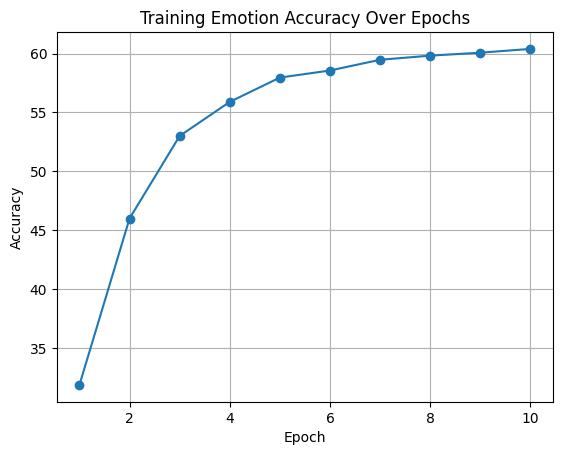

In [ ]:
import matplotlib.pyplot as plt

# Sample accuracy data for 8 training epochs
epoch_numbers = [1, 2, 3, 4, 5, 6, 7, 8,9,10]
accuracies = accuracies_emotion_base
losses = losses_emotion_base

# Plotting the accuracies
plt.plot(epoch_numbers, accuracies, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Emotion Accuracy Over Epochs')

# Adding grid for better readability
plt.grid(True)

# Saving the plot as a PNG file
plt.savefig('training_emotion_accuracy.png')

# Displaying the plot
plt.show()

In [ ]:
losses_sentiment_base, accuracies_sentiment_base = train_epoch_base(classifier_sentiment_base, train_sentiment, len(yelp_text)//batch_size, 14)

Epoch 1 Loss 0.9777
Epoch 1 Accuracy 42.3438
Epoch 2 Loss 0.7545
Epoch 2 Accuracy 52.7031
Epoch 3 Loss 0.5833
Epoch 3 Accuracy 59.4375
Epoch 4 Loss 0.4157
Epoch 4 Accuracy 65.3750
Epoch 5 Loss 0.2732
Epoch 5 Accuracy 70.1719
Epoch 6 Loss 0.1766
Epoch 6 Accuracy 73.1562
Epoch 7 Loss 0.1067
Epoch 7 Accuracy 75.2812
Epoch 8 Loss 0.0686
Epoch 8 Accuracy 76.3594
Epoch 9 Loss 0.0399
Epoch 9 Accuracy 77.1094
Epoch 10 Loss 0.0253
Epoch 10 Accuracy 77.4688
Epoch 11 Loss 0.0138
Epoch 11 Accuracy 77.7031
Epoch 12 Loss 0.0059
Epoch 12 Accuracy 77.8750


# LN-LSTM Encoder cell

In [17]:

import tensorflow as tf

# To DO: trainability of layers (for fine-tuning)
class LNLSTMCell(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, trainable=True, dropout=0.3):
        super(LNLSTMCell, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size
        self.trainable = trainable

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)

        # Dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate= dropout)

        self.embedding_layer = tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim,
          weights=[embedding_matrix],
          mask_zero=True,
          trainable=True)

        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= self.trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= self.trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= self.trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)


    def call(self, task, input_, hx):
        h, c = hx
        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
        else:
          raise ValueError('Key Error')

        input = self.embedding_layer(input_)

        # Create a mask for the input based on non-zero values
        mask = tf.math.not_equal(input_, 0)
        mask = tf.cast(mask, dtype=input.dtype)
        # Broadcast the mask to match the shape of gates
        mask = tf.expand_dims(mask, axis=-1)


        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout


        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        c_new = c_new * mask + c * (1 - mask)  # Masked cell state remains unchanged
        h_new = output_gate * tf.tanh(ln_c(c_new))
        h_new = h_new * mask + h * (1 - mask)  # Masked hidden state remains unchanged

        return h_new, c_new

    def initialize_hidden_state(self, batch_size):
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]


In [18]:
seq_len = np.shape(example_input_batch_emotion)[1]

In [19]:
ln_lstm = LNLSTMCell(embedding_dim= embedding_dim, hidden_size= 128, trainable=True)
outputs = tf.TensorArray(tf.float32, size=seq_len)

for t in range(seq_len):
  x = example_input_batch_emotion[:, t]
  initial = ln_lstm.initialize_hidden_state(batch_size=batch_size)
  h, c = ln_lstm.call('emotion',x, initial)
  outputs = outputs.write(t, h)
outputs = outputs.stack()
outputs = tf.transpose(outputs, [1,0,2])

In [20]:
print(np.shape(outputs))

(64, 25, 128)


# MultiTaskClassifier

## Task Embedding

In [22]:
import tensorflow as tf

class TaskEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_tasks, embedding_dim, trainable=True):
        super(TaskEmbedding, self).__init__()
        self.num_tasks = num_tasks
        self.embedding_dim = embedding_dim

        # Create a trainable weight variable for this layer.
        self.embedding_weights = self.add_weight(
            shape=(num_tasks, embedding_dim),
            initializer='random_normal',
            trainable=trainable
        )

    def call(self, task_indices):
        # Retrieve task embeddings based on task indices
        task_embeddings = tf.nn.embedding_lookup(self.embedding_weights, task_indices)
        return task_embeddings


In [23]:
# Testing :

# Define the number of tasks and embedding dimension
num_tasks = 3

# Create an instance of TaskEmbedding
task_embedding = TaskEmbedding(num_tasks, 32)

# Create a tensor of task indices
task_indices = tf.constant([0, 1, 2], dtype=tf.int32)

# Get task embeddings
task_embeddings = task_embedding(task_indices)

# The task_embeddings tensor will contain the trainable embeddings for each task.


In [24]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)
        self.units = units

        #Attention LN
        self.ln_emotion_a = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_a = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_a = tf.keras.layers.LayerNormalization(axis=1)

        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(self.units, self.units),
            initializer='uniform',
            trainable=True
        )


    def call(self, encoder_outputs, decoder_hidden, task):
        if task == 'emotion':
          ln_a = self.ln_emotion_a

        elif task == 'sentiment':
          ln_a = self.ln_sentiment_a

        elif task == 'new':
          ln_a = self.ln_new_a

        else:
          raise ValueError('Key Error')

        # Expand dimensions of decoder hidden state for compatibility
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, axis=1)

        # Calculate attention scores
        attention_scores = ln_a(tf.matmul(decoder_hidden_with_time_axis, self.attention_weights))
        attention_scores = tf.matmul(attention_scores, encoder_outputs, transpose_b=True)

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention weights to encoder outputs
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        context_vec = tf.reshape(context_vector, (np.shape(context_vector)[0], np.shape(context_vector)[-1]))
        attention_weights = tf.reshape(attention_weights, (np.shape(attention_weights)[0], np.shape(attention_weights)[-1]))

        return context_vector, attention_weights


## LN-LSTM Classifier

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class LNLSTMClassifier_with_Attention(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3):
        super(LNLSTMClassifier_with_Attention, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size


        # get task specific embedding
        self.task_embedding = TaskEmbedding(num_tasks=2, embedding_dim= self.input_size)
        self.Attention = LuongAttention(self.hidden_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)

        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)

        # Classification parameters
        self.dense_emotion_h_1 = Dense(units=16, activation='relu')
        self.dense_emotion_h_2 = Dense(units=4, activation='relu')
        self.dense_emotion_c_1 = Dense(units=16, activation='relu')
        self.dense_emotion_c_2 = Dense(units=4, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')


        self.dense_sentiment_h_1 = Dense(units=16, activation='relu')
        self.dense_sentiment_h_2 = Dense(units=4, activation='relu')
        self.dense_sentiment_c_1 = Dense(units=16, activation='relu')
        self.dense_sentiment_c_2 = Dense(units=4, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.dense_new_h_1 = Dense(units=16, activation='relu')
        self.dense_new_h_2 = Dense(units=4, activation='relu')
        self.dense_new_c_1 = Dense(units=16, activation='relu')
        self.dense_new_c_2 = Dense(units=4, activation='relu')
        self.softmax_new = Dense(units=num_classes_sentiment, activation='softmax')


    def call(self, task, task_indices, hx, encoder_outputs):
        h, c = hx

        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c
          dense_h_1 = self.dense_emotion_h_1
          dense_h_2 = self.dense_emotion_h_2
          dense_c_1 = self.dense_emotion_c_1
          dense_c_2 = self.dense_emotion_c_2
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c
          dense_h_1 = self.dense_sentiment_h_1
          dense_h_2 = self.dense_sentiment_h_2
          dense_c_1 = self.dense_sentiment_c_1
          dense_c_2 = self.dense_sentiment_c_2
          soft_max = self.softmax_sentiment

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
          dense_h_1 = self.dense_new_h_1
          dense_h_2 = self.dense_new_h_2
          dense_c_1 = self.dense_new_c_1
          dense_c_2 = self.dense_new_c_2
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.task_embedding(task_indices)

        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(ln_c(c_new))
        context_vector, attention_weights = self.Attention(encoder_outputs, h_new, task)
        h_new = self.dropout_layer(h_new)
        h_new = dense_h_1(h_new)
        h_new = dense_h_2(h_new)

        context_vector = tf.reshape(context_vector, (np.shape(context_vector)[0], np.shape(context_vector)[-1]))
        context_vector = self.dropout_layer(context_vector)
        context_vector = dense_c_1(context_vector)
        context_vector = dense_c_2(context_vector)

        new_hidden = tf.concat([h_new, context_vector], axis= -1)

        # Classify using hidden state
        output = soft_max(new_hidden)
        return output, attention_weights


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

In [27]:
ln_classifier = LNLSTMClassifier_with_Attention(embedding_dim=16, hidden_size=128, dropout=0.3)
z = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
out, attention_weights = ln_classifier.call(task='new',task_indices=z, hx=[h,c], encoder_outputs = outputs)

## Classifier(separate variables for each task)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class MultiTaskClassifier(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3, num_classes_new=2):
        super(MultiTaskClassifier, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size

        # get task specific embedding
        self.task_embedding = TaskEmbedding(num_tasks=3, embedding_dim= self.input_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        self.weight_ih_emotion = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_emotion_with_dropout = self.dropout_layer(self.weight_ih_emotion)
        self.weight_hh_emotion = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_emotion_with_dropout = self.dropout_layer(self.weight_hh_emotion)
        self.bias_emotion = self.add_weight(shape=(4 * hidden_size,))
        self.bias_emotion_with_dropout = self.dropout_layer(self.bias_emotion)
        self.dense_emotion = Dense(units=32, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')

        self.weight_ih_sentiment = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_sentiment_with_dropout = self.dropout_layer(self.weight_ih_sentiment)
        self.weight_hh_sentiment = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_sentiment_with_dropout = self.dropout_layer(self.weight_hh_sentiment)
        self.bias_sentiment = self.add_weight(shape=(4 * hidden_size,))
        self.bias_sentiment_with_dropout = self.dropout_layer(self.bias_sentiment)
        self.dense_sentiment = Dense(units=32, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.weight_ih_new = self.add_weight(shape=(self.input_size, 4 * hidden_size))
        self.weight_ih_new_with_dropout = self.dropout_layer(self.weight_ih_new)
        self.weight_hh_new = self.add_weight(shape=(hidden_size, 4 * hidden_size))
        self.weight_hh_new_with_dropout = self.dropout_layer(self.weight_hh_new)
        self.bias_new = self.add_weight(shape=(4 * hidden_size,))
        self.bias_new_with_dropout = self.dropout_layer(self.bias_new)
        self.dense_new = Dense(units=32, activation='relu')
        self.softmax_new = Dense(units=num_classes_new, activation='softmax') # num_classes_new could be different based on new task considered for fine tuning


    def call(self, task, task_indices, hx):
        h, c = hx
        if task == 'emotion':
          weight_ih = self.weight_ih_emotion_with_dropout
          weight_hh = self.weight_hh_emotion_with_dropout
          bias = self.bias_emotion_with_dropout
          dense = self.dense_emotion
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          weight_ih = self.weight_ih_sentiment_with_dropout
          weight_hh = self.weight_hh_sentiment_with_dropout
          bias = self.bias_sentiment_with_dropout
          dense = self.dense_sentiment
          soft_max = self.softmax_sentiment

        elif task == 'new':
          weight_ih = self.weight_ih_new_with_dropout
          weight_hh = self.weight_hh_new_with_dropout
          bias = self.bias_new_with_dropout
          dense = self.dense_new
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.task_embedding(task_indices)

        gates = tf.matmul(input, weight_ih) + tf.matmul(h, weight_hh) + bias

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(c_new)

        # Classify using hidden state
        dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(h_new)
        dense_output = dense(dropout_hidden)
        dropout_dense = tf.keras.layers.Dropout(rate=0.1)(dense_output)
        output = soft_max(dropout_dense)
        return output


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

In [ ]:
classifier = MultiTaskClassifier(embedding_dim=32, hidden_size=256)

In [ ]:
z = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
out = classifier.call(task='emotion',task_indices=z, hx=[h,c])

## LN-LSTM Classifier without learnable Embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense

# To DO: trainability of layers (for fine-tuning)
class LNLSTMClassifier_no_emb(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, dropout=0.3, trainable=True, num_classes_emotion=4, num_classes_sentiment=3, num_classes_new=2):
        super(LNLSTMClassifier_no_emb, self).__init__()
        self.input_size = embedding_dim
        self.hidden_size = hidden_size

        # get task specific embedding
        #self.task_embedding = TaskEmbedding(num_tasks=3, embedding_dim= self.input_size)

        # dropout
        self.dropout_layer = tf.keras.layers.Dropout(rate=dropout)

        # Layer Normalization
        self.ln_emotion_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_emotion_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_sentiment_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_sentiment_c = tf.keras.layers.LayerNormalization(axis=1)

        self.ln_new_x = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_h = tf.keras.layers.LayerNormalization(axis=1)
        self.ln_new_c = tf.keras.layers.LayerNormalization(axis=1)


        # LSTM parameters
        self.weight_ih = self.add_weight(shape=(self.input_size, 4 * hidden_size), trainable= trainable)
        self.weight_ih_with_dropout = self.dropout_layer(self.weight_ih)
        self.weight_hh = self.add_weight(shape=(hidden_size, 4 * hidden_size), trainable= trainable)
        self.weight_hh_with_dropout = self.dropout_layer(self.weight_hh)
        self.bias = self.add_weight(shape=(4 * hidden_size,), trainable= trainable)
        self.bias_with_dropout = self.dropout_layer(self.bias)

        # Classification parameters
        self.dense_emotion = Dense(units=32, activation='relu')
        self.softmax_emotion = Dense(units=num_classes_emotion, activation='softmax')

        self.dense_sentiment = Dense(units=32, activation='relu')
        self.softmax_sentiment = Dense(units=num_classes_sentiment, activation='softmax')

        self.dense_new = Dense(units=32, activation='relu')
        self.softmax_new = Dense(units=num_classes_new, activation='softmax') # num_classes_new could be different based on new task considered for fine tuning


    def call(self, task, batch_size, hx):
        h, c = hx

        if task == 'emotion':
          ln_x = self.ln_emotion_x
          ln_h = self.ln_emotion_h
          ln_c = self.ln_emotion_c
          dense = self.dense_emotion
          soft_max = self.softmax_emotion

        elif task == 'sentiment':
          ln_x = self.ln_sentiment_x
          ln_h = self.ln_sentiment_h
          ln_c = self.ln_sentiment_c
          dense = self.dense_sentiment
          soft_max = self.softmax_sentiment

        elif task == 'new':
          ln_x = self.ln_new_x
          ln_h = self.ln_new_h
          ln_c = self.ln_new_c
          dense = self.dense_new
          soft_max = self.softmax_new

        else:
          raise ValueError('Key Error')


        input = self.initialize_input(batch_size)

        gates = ln_x(tf.matmul(input, self.weight_ih_with_dropout)) + ln_h(tf.matmul(h, self.weight_hh_with_dropout)) + self.bias_with_dropout

        # Split the gates into input, forget, cell, and output gates
        input_gate, forget_gate, cell_gate, output_gate = tf.split(gates, 4, axis=-1)

        # Apply sigmoid activation to the gates
        input_gate = tf.sigmoid(input_gate)
        forget_gate = tf.sigmoid(forget_gate)
        cell_gate = tf.tanh(cell_gate)
        output_gate = tf.sigmoid(output_gate)

        # Update the cell and hidden state
        c_new = c * forget_gate + input_gate * cell_gate
        h_new = output_gate * tf.tanh(ln_c(c_new))

        # Classify using hidden state
        dropout_hidden = tf.keras.layers.Dropout(rate=0.3)(h_new)
        dense_output = dense(dropout_hidden)
        dropout_dense = tf.keras.layers.Dropout(rate=0.2)(dense_output)
        output = soft_max(dropout_dense)
        return output


    def initialize_hidden_state(self, batch_size): # actually, not necessary, cause gets inputs from encoder
      return [tf.zeros((batch_size, self.hidden_size)), tf.zeros((batch_size, self.hidden_size))]

    def initialize_input(self, batch_size):
      return [tf.zeros((batch_size, self.input_size)), tf.zeros((batch_size, self.input_size))]

In [ ]:
ln_no_emb = LNLSTMClassifier_no_emb(32, 256)
a = ln_no_emb.initialize_input(64)
print(np.shape(a))

(2, 64, 32)


# Training

In [28]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(0.001)

#Loss
def loss_function(real, pred):
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = cross_entropy(y_true= real, y_pred= pred)
  loss = tf.reduce_mean(loss)
  return loss

In [29]:
# Define Models
batch_size = batch_size
Encoder = LNLSTMCell(embedding_dim= 100, hidden_size= 128)
Classifier = LNLSTMClassifier_with_Attention(embedding_dim= 16, hidden_size= 128)

In [30]:
# Path to save models
model_save_name= "LNLSTM/with_attention.ckpt"
path= F"/content/gdrive/My Drive/Model_checkpoints/{model_save_name}"

In [31]:
# Checkpoint_save

checkpoint = tf.train.Checkpoint(optiimizer=optimizer,
                                 Encoder=Encoder,
                                 Classifier=Classifier)
# Checkpoint_lr

In [32]:
# Train Step

def train_step(task, text, label):

  with tf.GradientTape() as tape:
    outputs = tf.TensorArray(tf.float32, size= np.shape(text)[1])
    h, c = Encoder.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder.call(task, text[:, t], [h,c])
      outputs = outputs.write(t, h)
    outputs = outputs.stack()
    outputs = tf.transpose(outputs, [1,0,2])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')
    # Classification
    out_probs, _ = Classifier.call(task=task, task_indices= task_indices, hx=[h,c], encoder_outputs = outputs)

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables based on task
    variables = Encoder.trainable_variables + Classifier.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [33]:
batch_size = 64
steps_emotion= len(emotion_text)//batch_size
steps_sentiment = len(yelp_text)//batch_size

In [36]:
epochs = 4
losses_emotion = []
losses_sentiment = []

accuracies_emotion = []
accuracies_sentiment = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment.append(total_loss / steps_sentiment)
    accuracies_sentiment.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion.append(total_loss / steps_emotion)
    accuracies_emotion.append(total_accuracy / steps_emotion)

Epoch 0 Loss Sentiment0.1852
Epoch 1 Accuracy Sentiment0.9459


Epoch 0 Loss Emotion0.1882
Epoch 2 Accuracy Emotion0.9178


Epoch 1 Loss Sentiment0.1241
Epoch 3 Accuracy Sentiment0.9665


Epoch 1 Loss Emotion0.1694
Epoch 4 Accuracy Emotion0.9173


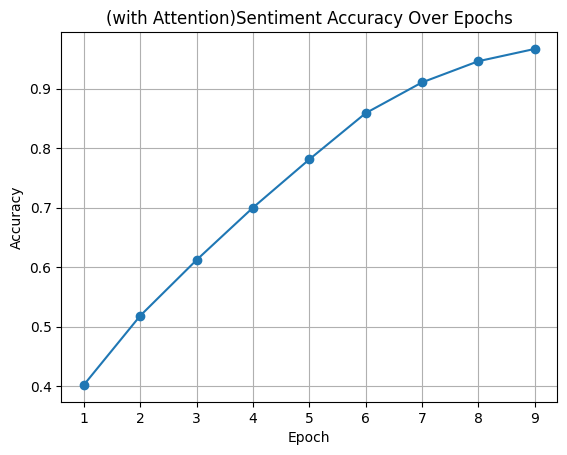

In [60]:
import matplotlib.pyplot as plt

# Sample accuracy data for 8 training epochs
epoch_numbers = [1, 2, 3, 4, 5, 6, 7, 8,9]
accuracies = accuracies_sentiment_0 + accuracies_sentiment


# Plotting the accuracies
plt.plot(epoch_numbers, accuracies, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('(with Attention)Sentiment Accuracy Over Epochs')

# Adding grid for better readability
plt.grid(True)

# Saving the plot as a PNG file
plt.savefig('attention_sentiment_accuracy.png')

# Displaying the plot
plt.show()

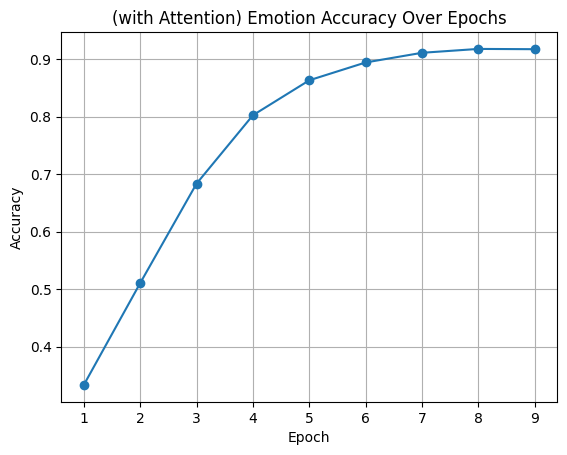

In [61]:
import matplotlib.pyplot as plt

# Sample accuracy data for 8 training epochs
epoch_numbers = [1, 2, 3, 4, 5, 6, 7, 8,9]
accuracies = accuracies_emotion_0 + accuracies_emotion


# Plotting the accuracies
plt.plot(epoch_numbers, accuracies, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('(with Attention) Emotion Accuracy Over Epochs')

# Adding grid for better readability
plt.grid(True)

# Saving the plot as a PNG file
plt.savefig('attention_emotion_accuracy.png')

# Displaying the plot
plt.show()

In [35]:
losses_sentiment_0 = losses_sentiment
accuracies_sentiment_0 = accuracies_sentiment
losses_emotion_0 = losses_emotion
accuracies_emotion_0 = accuracies_emotion

In [ ]:
accuracies_sentiment

[<tf.Tensor: shape=(), dtype=float32, numpy=0.45753205>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.56189907>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.68409455>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8066907>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9016426>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95653045>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98397434>]

In [ ]:
losses_emotion

[<tf.Tensor: shape=(), dtype=float32, numpy=1.2710248>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95323414>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65045595>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.43758708>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.303985>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.22922002>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1909089>]

In [ ]:
accuracies_emotion

[<tf.Tensor: shape=(), dtype=float32, numpy=0.40360576>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.61346155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7502404>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8408654>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8894231>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.90889424>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.91778845>]

In [ ]:
# Define Models
batch_size = batch_size
Encoder_separate = LNLSTMCell(embedding_dim= 100, hidden_size= 256)
Classifier_separate = MultiTaskClassifier(embedding_dim= 32, hidden_size= 256)

In [ ]:
# Train Step

def train_step_separate(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder_separate.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder_separate.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_separate.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder_separate.trainable_variables + Classifier_separate.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
epochs = 14
losses_emotion_separate = []
losses_sentiment_separate = []

accuracies_emotion_separate = []
accuracies_sentiment_separate = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment_separate.append(total_loss / steps_sentiment)
    accuracies_sentiment_separate.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion_separate.append(total_loss / steps_emotion)
    accuracies_emotion_separate.append(total_accuracy / steps_emotion)

In [ ]:
batch_size = batch_size
Encoder_no_emb = LNLSTMCell(embedding_dim= 100, hidden_size= 256)
Classifier_no_emb = LNLSTMClassifier_no_emb(embedding_dim= 32, hidden_size= 256)

In [ ]:
# Train Step

def train_step_no_emb(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder_no_emb.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder_no_emb.call(task, text[:, t], [h,c])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_no_emb.call(task=task, batch_size=batch_size, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder_no_emb.trainable_variables + Classifier_no_emb.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
epochs = 14
losses_emotion_no_emb= []
losses_sentiment_no_emb = []

accuracies_emotion_no_emb = []
accuracies_sentiment_no_emb = []

for epoch in range(epochs):
  if epoch % 2 == 0:
    task = 'sentiment'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_sentiment.take(steps_sentiment)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    print('Epoch {} Loss Sentiment{:.4f}'.format((epoch+1)//2,
                                        total_loss / steps_sentiment))
    print('Epoch {} Accuracy Sentiment{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_sentiment))
    losses_sentiment_no_emb.append(total_loss / steps_sentiment)
    accuracies_sentiment_no_emb.append(total_accuracy / steps_sentiment)

  else:
    task = 'emotion'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_emotion.take(steps_emotion)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss Emotion{:.4f}'.format(epoch//2,
                                        total_loss / steps_emotion))
    print('Epoch {} Accuracy Emotion{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_emotion))
    losses_emotion_no_emb.append(total_loss / steps_emotion)
    accuracies_emotion_no_emb.append(total_accuracy / steps_emotion)

# Evaluation

In [62]:
# Train Step
def evaluate(task, text, label):

    outputs = tf.TensorArray(tf.float32, size= np.shape(text)[1])
    h, c = Encoder.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder.call(task, text[:, t], [h,c])
      outputs = outputs.write(t, h)
    outputs = outputs.stack()
    outputs = tf.transpose(outputs, [1,0,2])

    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')
    # Classification
    out_probs, _ = Classifier.call(task=task, task_indices= task_indices, hx=[h,c], encoder_outputs = outputs)

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = (tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32)))

    return accuracy

In [63]:
ds_name = "emotion_test.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [64]:
emotion_text_test = ds['text']
emotion_label_test = ds['label']

In [65]:
print(len(emotion_text_test))

120


In [66]:
buffer_size_emotion = 150
batch_size = 120
max_len = 25

preprocess = Preprocess_classification(vocab)
test_emotion = preprocess.create_dataset(emotion_text_test, emotion_label_test, max_len, buffer_size_emotion, batch_size)

<ipython-input-13-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [69]:
task = 'emotion'
for (batch, (text, label)) in enumerate(test_emotion.take(1)):
  batch_accuracy = evaluate(task, text, label)


In [70]:
batch_accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.8375>

# Fine Tuning

## Preparing data

In [ ]:
ds_name = "imdb_train.csv"
path= F"/content/gdrive/My Drive/Database/{ds_name}"
ds = pd.read_csv(path)

In [ ]:
imdb_text = ds['text']
imdb_label = ds['label']

In [ ]:
buffer_size_imdb = 2100
batch_size_imdb = 64
max_len = 25

imdb_process = Preprocess_classification(vocab)
train_imdb = imdb_process.create_dataset(imdb_text, imdb_label, max_len, buffer_size_imdb, batch_size_imdb)

<ipython-input-11-79cb1ed4c48f>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Text = np.array([self.preprocess_sentence(w) for w in text])


In [ ]:
# On base model
classifier_imdb_base = Basic_Classifier(batch_size= 64, units= 256, num_classes= 2)

In [ ]:
losses_imdb_base, accuracies_imdb_base = train_epoch_base(classifier_imdb_base, train_imdb, len(imdb_text)//batch_size, 9)

Epoch 1 Loss 0.6859
Epoch 1 Accuracy 18.1094
Epoch 2 Loss 0.4433
Epoch 2 Accuracy 24.9688
Epoch 3 Loss 0.1973
Epoch 3 Accuracy 28.6562
Epoch 4 Loss 0.0725
Epoch 4 Accuracy 30.3750
Epoch 5 Loss 0.0189
Epoch 5 Accuracy 30.8438
Epoch 6 Loss 0.0076
Epoch 6 Accuracy 30.9531
Epoch 7 Loss 0.0046
Epoch 7 Accuracy 30.9844
Epoch 8 Loss 0.0034
Epoch 8 Accuracy 30.9844
Epoch 9 Loss 0.0028
Epoch 9 Accuracy 30.9844


In [ ]:
Encoder.trainable = False
Classifier_fine_tune = LNLSTMClassifier(embedding_dim= 32, hidden_size= 256)

In [ ]:
batch_size = 64
steps_new= len(imdb_text)//batch_size

In [ ]:
# Train Step

def train_step(task, text, label):

  with tf.GradientTape() as tape:
    h, c = Encoder.initialize_hidden_state(batch_size=batch_size)
    # Encoding
    for t in range(np.shape(text)[1]):
      h, c = Encoder.call(task, text[:, t], [h,c])
    task_index = 0
    if task == 'emotion':
      task_indices = tf.constant([0 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'sentiment':
      task_indices = tf.constant([1 for i in range(batch_size)], dtype=tf.int32)
    elif task == 'new':
      task_indices = tf.constant([2 for i in range(batch_size)], dtype=tf.int32)
    else:
      raise ValueError('Key error')

    # Classification
    out_probs = Classifier_fine_tune.call(task=task, task_indices= task_indices, hx=[h,c])

    # Compute accuracy
    predicted_labels = tf.argmax(out_probs, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, predicted_labels), dtype=tf.float32))

    # Loss
    loss = loss_function(label, out_probs)

    # Get the watched variables
    variables = Encoder.trainable_variables + Classifier_fine_tune.trainable_variables

    # Compute gradients only for watched variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients to the watched variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, accuracy

In [ ]:
epochs = 9
losses_imdb= []

accuracies_imdb = []

for epoch in range(epochs):
    task = 'new'
    total_loss = 0
    total_accuracy = 0
    for (batch, (text, label)) in enumerate(train_imdb.take(steps_new)):
      batch_loss, batch_accuracy = train_step(task, text, label)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    #if (epoch+1) % 6 == 0:
    #  checkpoint.save(file_prefix = path)

    print('Epoch {} Loss imdb{:.4f}'.format(epoch+1,
                                        total_loss / steps_new))
    print('Epoch {} Accuracy imdb{:.4f}'.format(epoch+1,
                                        total_accuracy / steps_new))
    losses_imdb.append(total_loss / steps_new)
    accuracies_imdb.append(total_accuracy / steps_new)

Epoch 1 Loss imdb0.3530
Epoch 1 Accuracy imdb0.8679


Epoch 2 Loss imdb0.3203
Epoch 2 Accuracy imdb0.8896


In [ ]:
losses_imdb

[<tf.Tensor: shape=(), dtype=float32, numpy=0.35303882>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3203489>]

In [ ]:
accuracies_imdb

[<tf.Tensor: shape=(), dtype=float32, numpy=0.8679435>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8896169>]

In [ ]:
l = [float(i) for i in losses_imdb]
a = [float(i) for i in accuracies_imdb]

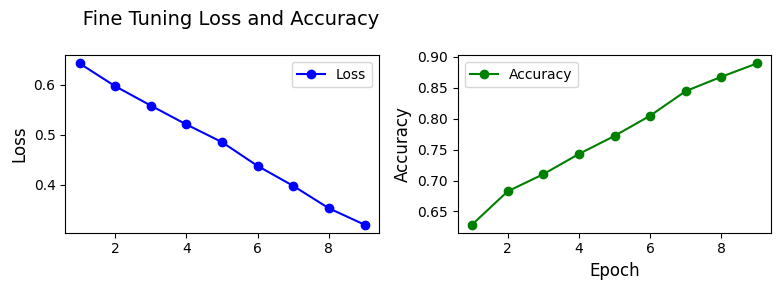

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
losses = l
accuracies = a

# Create subplots for losses and accuracies
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3), sharex=True)

# Plot for losses
ax1.plot(epochs, losses, marker='o', color='b', label='Loss')
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('   Fine Tuning Loss and Accuracy\n', fontsize=14)
ax1.legend()

# Plot for accuracies
ax2.plot(epochs, accuracies, marker='o', color='g', label='Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots as images (optional)
plt.savefig('loss_accuracy_plot.png', dpi=300)

# Show the plots
plt.show()
